In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

import statsmodels.distributions.copula.api as smt_cop

warnings.filterwarnings("ignore", "use_inf_as_na")
sns.set()
rng = np.random.default_rng(seed=42)

# Linear correlation vs. Rank correlations

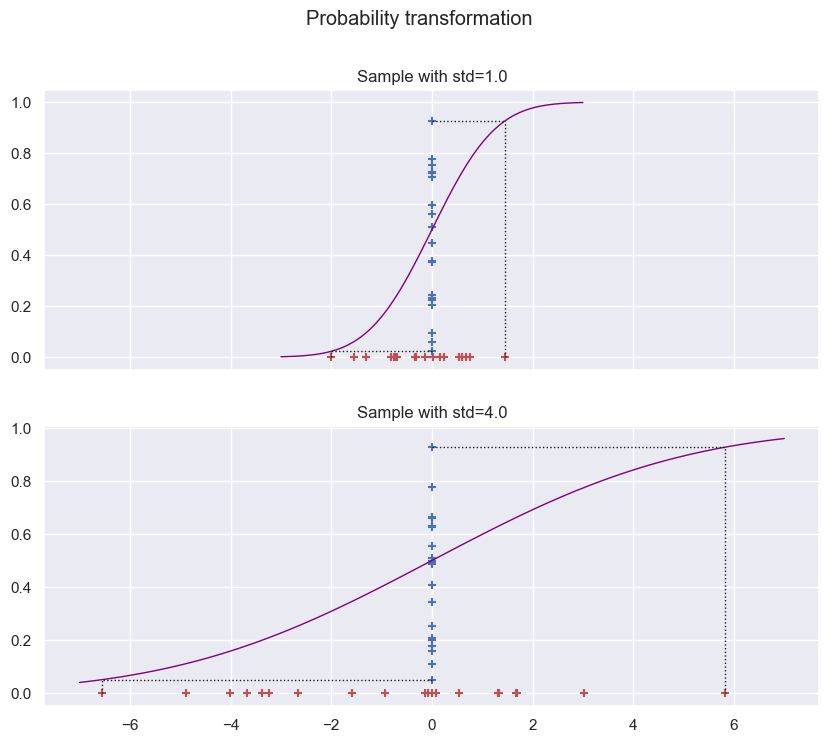

In [3]:
def plot_proba_transform_on_axis(ax, std, sample_size):
    dist = stats.norm(scale=std)
    sample = dist.rvs(size=sample_size)
    sample_unif = dist.cdf(sample)
    lim = np.ceil(np.maximum(-sample.min(), sample.max()))
    x = np.linspace(-lim, lim, 100)
    cdf = dist.cdf(x)
    s_min, s_max = sample.min(), sample.max()
    u_min, u_max = dist.cdf([s_min, s_max])
    
    ax.plot(x, cdf, c='purple', lw=1)
    ax.scatter(sample, np.zeros_like(sample), c='r', marker='+')
    ax.scatter(np.zeros_like(sample_unif), sample_unif, c='b', marker='+')
    ax.plot([s_min, s_min], [0, u_min], color='k', ls=':', lw=1)
    ax.plot([0, s_min], [u_min, u_min], color='k', ls=':', lw=1)
    ax.plot([s_max, s_max], [0, u_max], color='k', ls=':', lw=1)
    ax.plot([0, s_max], [u_max, u_max], color='k', ls=':', lw=1)
    ax.set_title(f"Sample with std={std:.1f}")

def plot_probability_transformation(stds=[1,4], sample_size=20):
    fig, axs = plt.subplots(2, figsize=(10,8), sharex=True)
    for ax, std in zip(axs, stds):
        plot_proba_transform_on_axis(ax, std, sample_size)
    fig.suptitle("Probability transformation")

plot_probability_transformation()

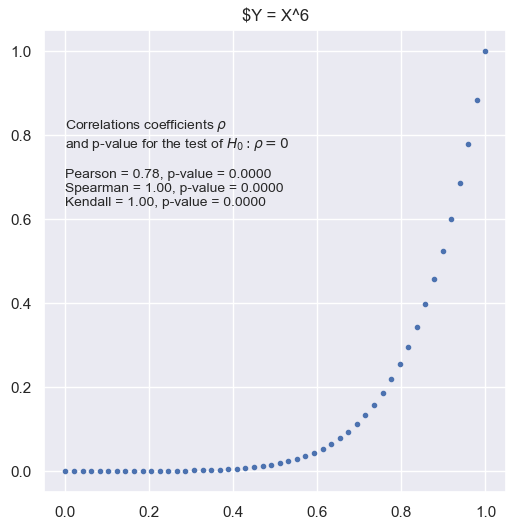

In [4]:
def linear_vs_rank_correlation(sample_size = 50):
    # data
    x = np.linspace(0, 1, sample_size)
    y = x ** 6
    
    # correlation coefficients
    correls = {}
    correls['Pearson'] = stats.pearsonr(x, y)
    correls['Spearman'] = stats.spearmanr(x, y)
    correls['Kendall'] = stats.kendalltau(x, y)
    
    # string to display
    label = r"Correlations coefficients $\rho$" + "\n"
    label += r"and p-value for the test of $H_0: \rho=0$" + "\n\n"
    for key in correls:
        c, pval = correls[key]
        label += f"{str(key)} = {c:.2f}, "
        label += f"p-value = {pval:.4f}"
        label += "\n"

    # plot
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'aspect': 'equal'})
    ax.scatter(x, y, marker='.')
    ax.text(0.0 ,0.6, label, fontsize='small')
    ax.set_title(r"$Y = X^6")

linear_vs_rank_correlation()

# Marginal distributions and dependence structure

We use the returns of the three asset classes which are in our portfolio.

In [5]:
returns = pd.read_excel('hist_data.xlsx').set_index('Date').pct_change().dropna()
returns.head()

SP500     Commo     TBond
Date                                    
2019-01-03 -0.025189  0.008431  0.012990
2019-01-04  0.034113 -0.007045 -0.011982
2019-01-07  0.007605  0.003196 -0.002553
2019-01-08  0.008626 -0.002798 -0.003200
2019-01-09  0.003887  0.004754 -0.003210

Use [`pandas.DataFrame.corr`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) to compute the correlation matrix of the returns.

In [6]:
corr = returns.corr()
corr

SP500     Commo     TBond
SP500  1.000000  0.068267 -0.144606
Commo  0.068267  1.000000  0.308807
TBond -0.144606  0.308807  1.000000

## Using only year 2019

For this exercise, we focus on year 2019 when the negative correlation between Equities and Fixed Income was stronger.

In [7]:
ret2020 = returns[:'2020']
corr = ret2020.corr()
corr

SP500     Commo     TBond
SP500  1.000000  0.063409 -0.401028
Commo  0.063409  1.000000  0.264644
TBond -0.401028  0.264644  1.000000

Apply [`seaborn.heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) to obtain a graphical representation of the correlation matrix.  
You will need the option `vmin=-1`. Specify a colormap such as `cmap='RdBu'`.  
Finally, try the option `annot=True`. In case the first row only has annotations, this is a known bug with the `annot=True` when using `matplotlib` version >= 3.8.0 and `seaborn` version <= 0.12.

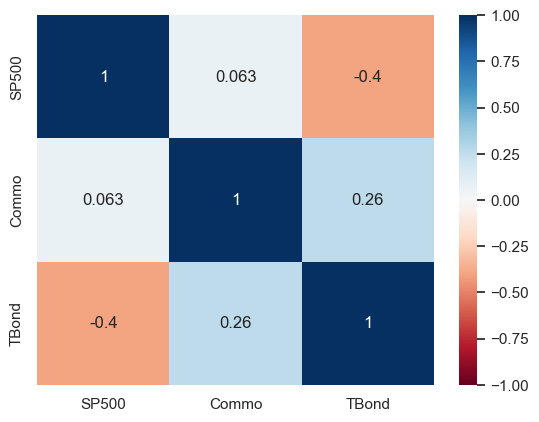

In [8]:
ax = sns.heatmap(corr, vmin=-1, vmax=1, cmap='RdBu', annot=True)

Apply [`seaborn.pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html). you can use the option `markers='.'`.

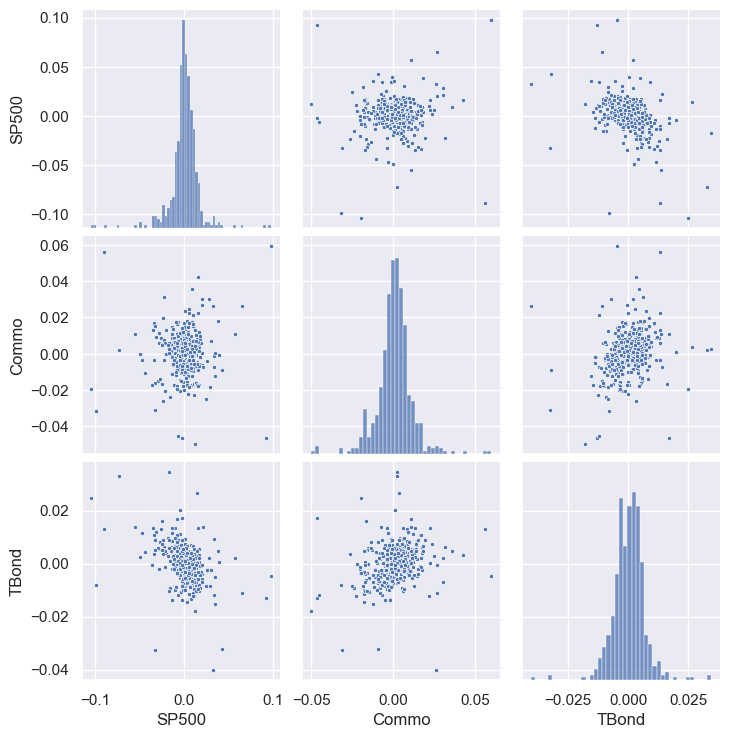

In [9]:
grid = sns.pairplot(ret2020, markers='.')

## Rank dependence

Estimate the marginal distributions of the three asset classes assuming they follow a Student's *t* distribution.

In [10]:
marginals = pd.DataFrame(
    data=np.array([list(stats.t.fit(ret2020[col])) for col in ret2020.columns]).T,
    index = ['df', 'loc', 'scale'],
    columns=ret2020.columns
)
marginals

SP500     Commo     TBond
df     2.057154  2.598834  3.984548
loc    0.001785  0.001167  0.000426
scale  0.007123  0.006292  0.004653

Use the marginal distributions for the probability transformation of the returns into Uniform(0,1) distributions.

In [11]:
ret2020_rank = pd.DataFrame(index=ret2020.index)
for col in ret2020.columns:
    df, loc, scale = marginals[col]
    ret2020_rank[col] = stats.t.cdf(ret2020[col], df=df, loc=loc, scale=scale)

ret2020_rank.head()

SP500     Commo     TBond
Date                                    
2019-01-03  0.030226  0.828325  0.972846
2019-01-04  0.978530  0.147701  0.028106
2019-01-07  0.751167  0.614401  0.278450
2019-01-08  0.782111  0.289807  0.239743
2019-01-09  0.602484  0.692936  0.239163

Display the correlation matrix and `pairplot` of the transformed returns.

In [12]:
corr_rank = ret2020_rank.corr()
corr_rank

SP500     Commo     TBond
SP500  1.000000 -0.014631 -0.399036
Commo -0.014631  1.000000  0.337967
TBond -0.399036  0.337967  1.000000

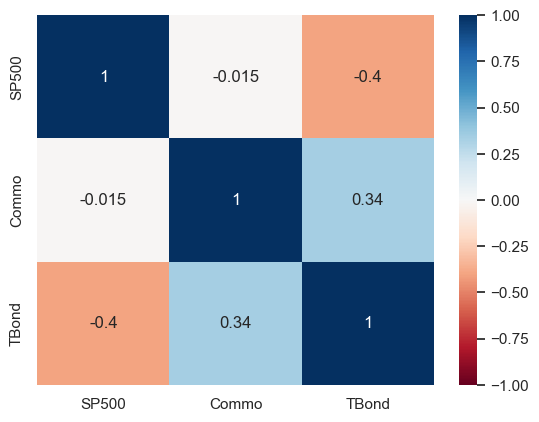

In [13]:
ax = sns.heatmap(  corr_rank, vmin=-1, vmax=1, cmap='RdBu', annot=True   )

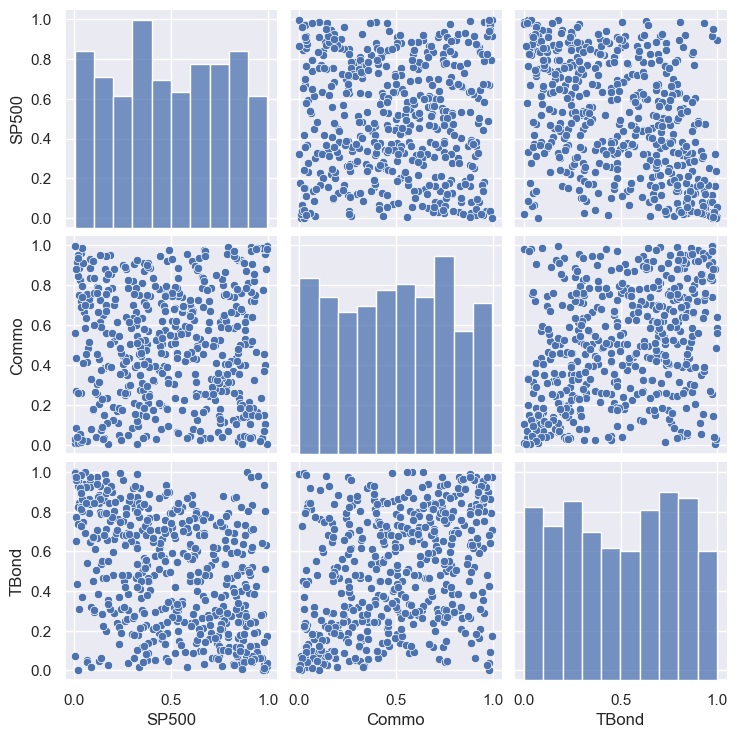

In [14]:
grid = sns.pairplot(ret2020_rank)

# Copulas

## Fundamental Copulas and Fréchet bounds

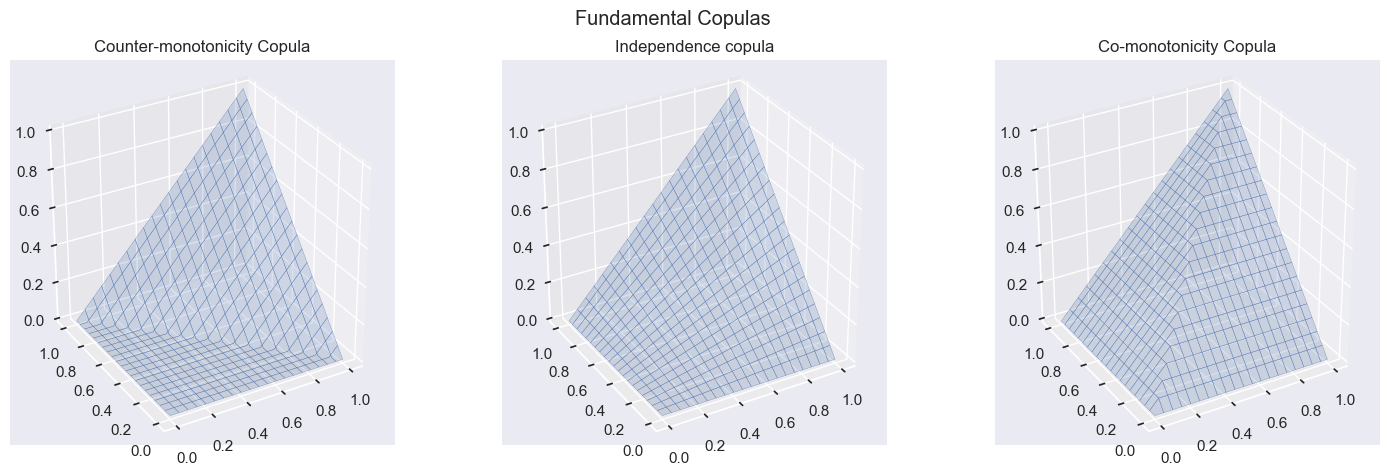

In [15]:
def plot_fundamental_copulas():
    x = np.linspace(0,1,100)
    X, Y = np.meshgrid(x, x)
    Z_indep = X * Y
    Z_comonotonic = np.minimum(X, Y)
    Z_countermonotonic = np.maximum(0, X+Y-1)
    data = [Z_countermonotonic ,Z_indep, Z_comonotonic]
    titles = ["Counter-monotonicity Copula", "Independence copula", "Co-monotonicity Copula"]

    fig, axs = plt.subplots(1, 3, figsize=(18,5), subplot_kw={'aspect': 'equal', 'projection': '3d'})
    for ax, Z, title in zip(axs, data, titles):
        ax.plot_surface(X, Y, Z, rcount=20, ccount=20, linewidth=0.2, edgecolor='b', alpha=0.2)
        ax.view_init(azim=-120)
        ax.set_title(title)
    fig.suptitle("Fundamental Copulas")

plot_fundamental_copulas()

## Implicit Copulas

In [16]:
def plot_copula(family, cop_params, cdf=False, sample_size=5000, rng=None, dist_arg=None):
    """
    cop_params: list, contains parametric copula parameters values
    dist_arg: dict, contains one additional parameter name and value for the distribution
              (e.g. {'df': 5} for Student's t)
    """
    match family:
        case 'Gaussian':
            cop = smt_cop.GaussianCopula
            cop_param_name = "correlation"
        case 't':
            cop = smt_cop.StudentTCopula
            cop_param_name = "correlation"
        case 'Frank':
            cop = smt_cop.FrankCopula
            cop_param_name = "theta"
        case 'Gumbel':
            cop = smt_cop.GumbelCopula
            cop_param_name = "theta"
        case 'Clayton':
            cop = smt_cop.ClaytonCopula
            cop_param_name = "theta"

    n_plots = len(cop_params)
    fig, axs = plt.subplots(1, n_plots, figsize=(5*n_plots,6),
                            subplot_kw={'aspect': 'equal'}, layout='tight')
    for ax, param in zip(axs, cop_params):
        match cop_param_name:
            case "correlation":
                frozen_cop = cop(corr=param, **dist_arg) if dist_arg else cop(corr=param)
            case "theta":
                frozen_cop = cop(theta=param)
        sample = frozen_cop.rvs(sample_size, random_state=rng)
        ax.scatter(sample[:,0], sample[:,1], marker='.', alpha=0.2)
        ax.set_title(cop_param_name+f" = {param}")
    fig.suptitle(family+" Copulas")

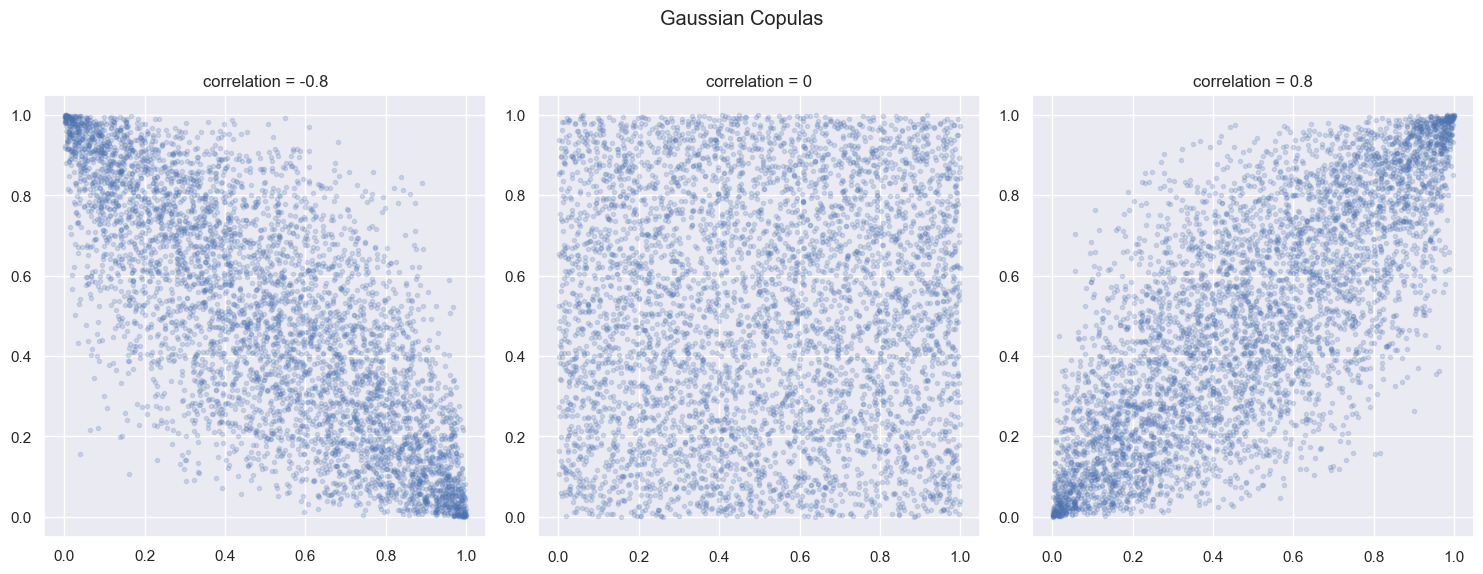

In [17]:
plot_copula(family='Gaussian', cop_params=[-0.8, 0, 0.8], rng=rng)

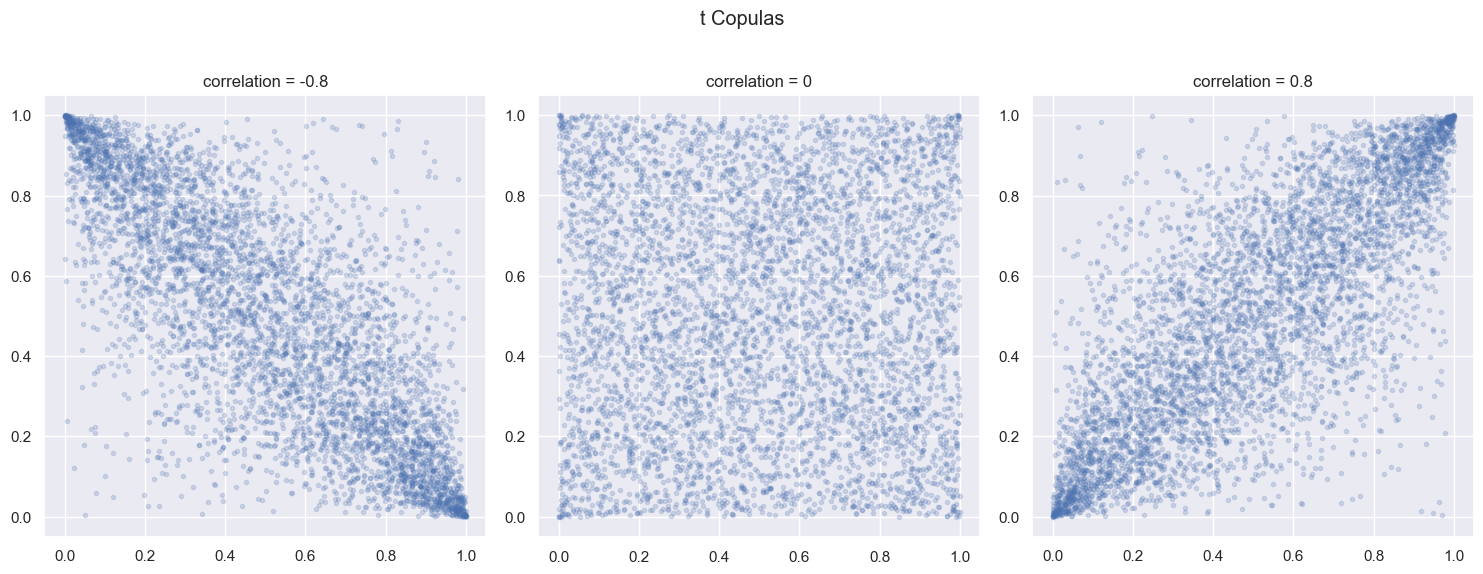

In [18]:
plot_copula(family='t', cop_params=[-0.8, 0, 0.8], dist_arg={'df': 5}, rng=rng)

## Archimedean Copulas

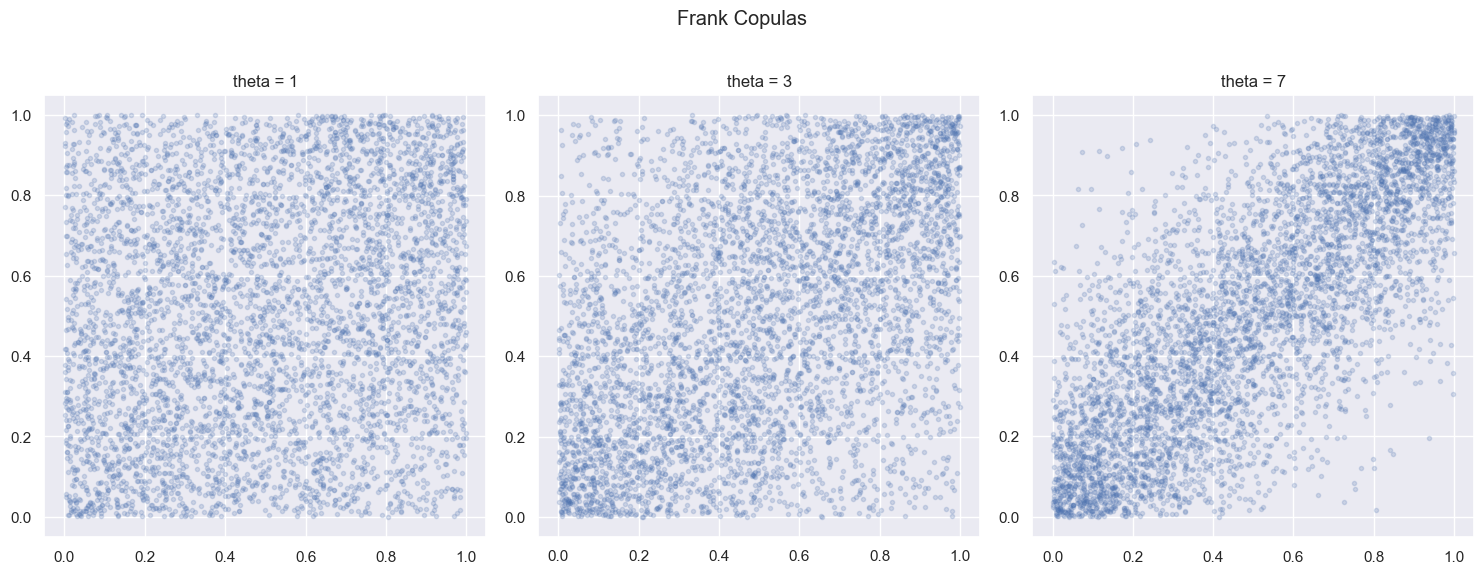

In [19]:
plot_copula(family='Frank', cop_params=[1, 3, 7], rng=rng)

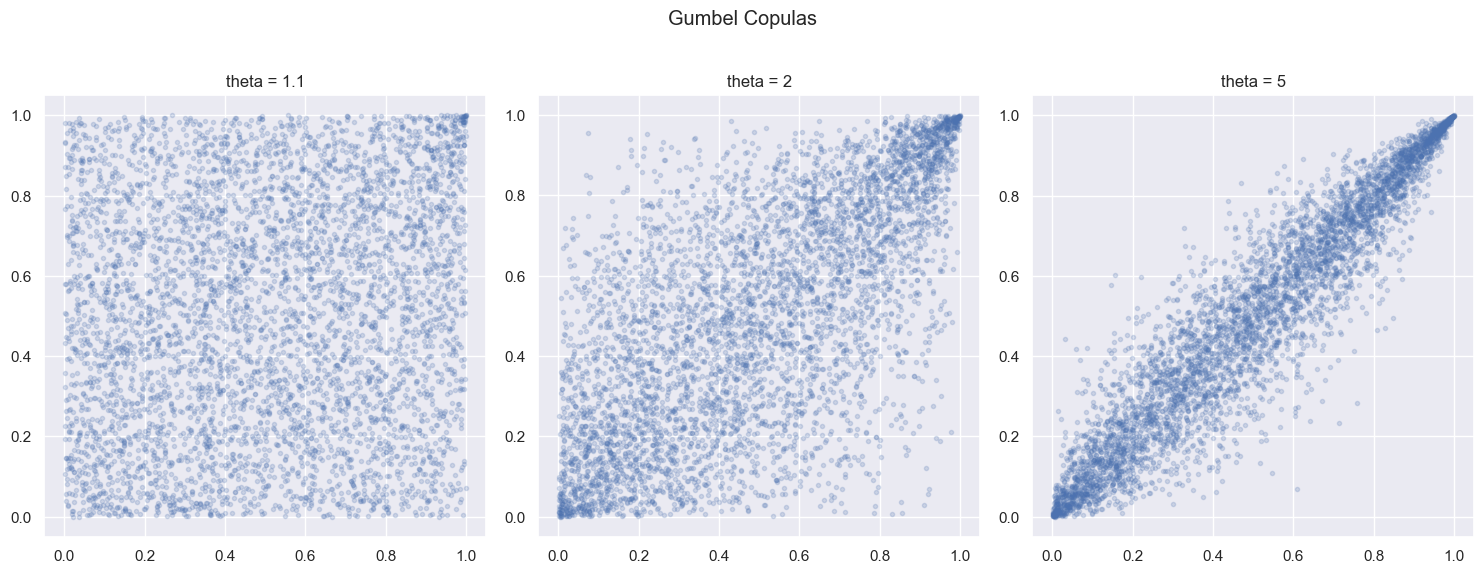

In [20]:
plot_copula(family='Gumbel', cop_params=[1.1, 2, 5], rng=rng)

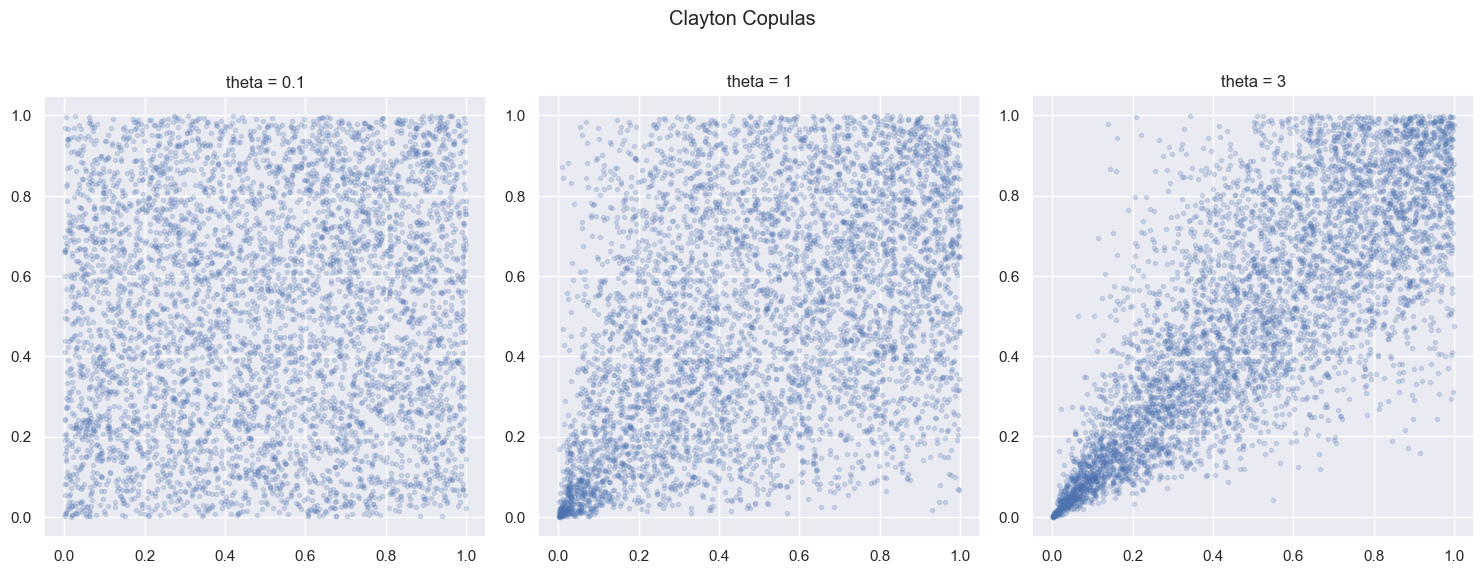

In [21]:
plot_copula(family='Clayton', cop_params=[0.1, 1, 3], rng=rng)

# Application to Risk Management

We apply the Monte Carlo method to estimate Value-at-Risk and Expected Shortfall.  
We generate the sample using Copulas and marginal distributions:
1. Generate a sample of uniformly distributed random variables with dependence defined by the Gumbel copula. The sample will present tail dependence.
2. Apply **Quantile Transformation** to the sample using the Student's *t* marginals which have been estimated above.
3. Compute the losses for all the obtained returns.
4. Compute the empirical risk measures.

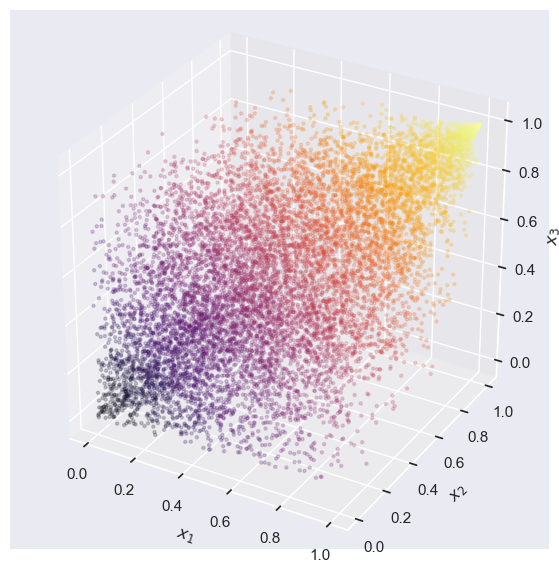

In [22]:
def plot_sample(sample):
    """
    3D scatter plot of a 3-dimensional dataset
    """
    x, y, z = [sample[:,i] for i in range(3)]
    fig, ax = plt.subplots(figsize=(9, 7), subplot_kw={'aspect': 'equal', 'projection': '3d'})
    ax.scatter(x, y, z, marker='.', alpha=0.2, c=(x+y+z)/3, cmap='inferno')
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_zlabel(r"$x_3$")
    
def sample_Gumbel(dim=3, theta=1.5, sample_size=10000):
    """
    Create a 3-dimensional sample from the Gumble copula
    """
    sample = smt_cop.GumbelCopula(k_dim=dim, theta=theta).rvs(sample_size, random_state=rng)
    plot_sample(sample)
    return sample
    
sample_unif = sample_Gumbel()

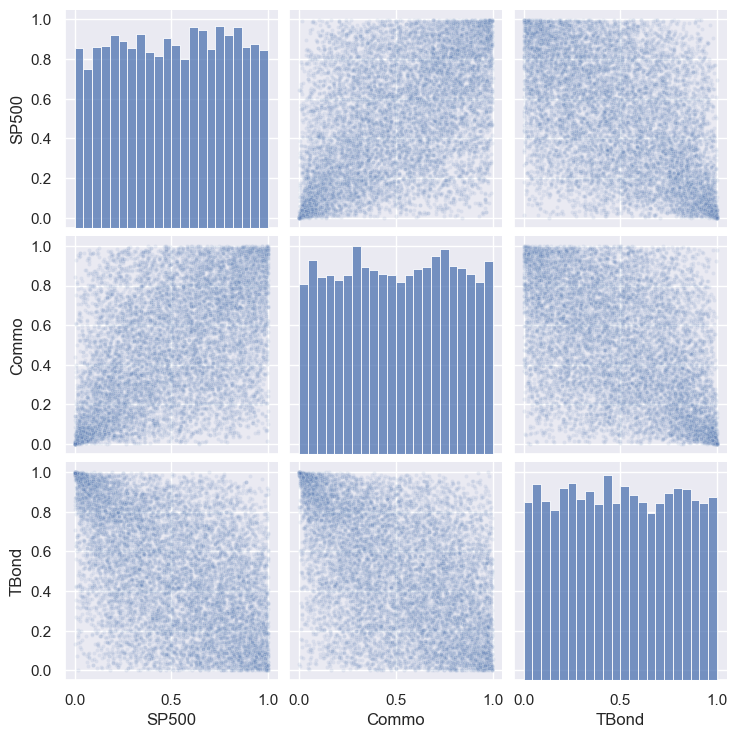

In [25]:
grid = sns.pairplot(pd.DataFrame(sample_unif, columns=['SP500', 'Commo', 'TBond']), markers='.', plot_kws={'alpha': .1})

We take the opposite of the Tbond simulated returns as we need tail dependence when Equities have a sharp down move and Fixed Income simultaneoulsy have a sharp move up.

In [24]:
sample_unif[:,0] = 1 - sample_unif[:,0]
sample_unif[:,1] = 1 - sample_unif[:,1]

In [26]:
def uniform_to_Student(sample_unif, marginals):
    sample = np.zeros_like(sample_unif)
    for i, col in enumerate(ret2020.columns):
        df, loc, scale = marginals[col]
        sample[:,i] = stats.t.ppf(sample_unif[:,i], df=df, loc=loc, scale=scale)
    return sample

sample = uniform_to_Student(sample_unif, marginals)

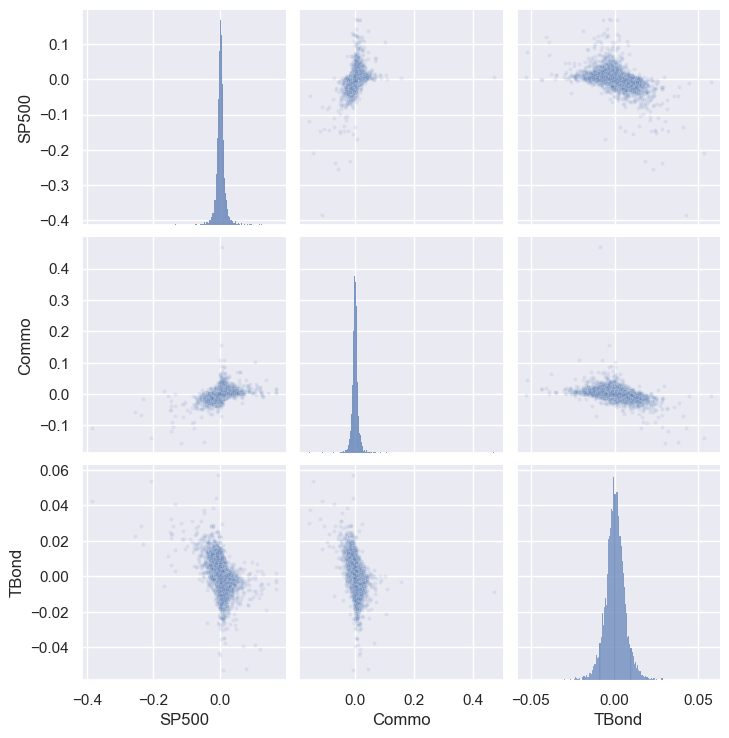

In [27]:
grid = sns.pairplot(pd.DataFrame(sample, columns=['SP500', 'Commo', 'TBond']), markers='.', plot_kws={'alpha': .1})

The lines below may be needed to eliminate samples where returns are lower than 100%.

In [30]:
sample.min(axis=0)

array([-0.3861091 , -0.15564144, -0.05300445])

In [ ]:
sample.argmin(axis=0)

In [ ]:
sample = np.delete(sample, 3588, axis=0)
sample.min(axis=0)

Compute the losses in million EUR when the portfolio value is 100 mEUR and the weights are 50%, 20%, 30%.  
Convert into pandas.Series to use with seaborn.

In [32]:
sample.shape

(10000, 3)

In [36]:
losses = -100 * sample @ np.array([0.5, 0.2, 0.3])
losses = pd.Series(losses)

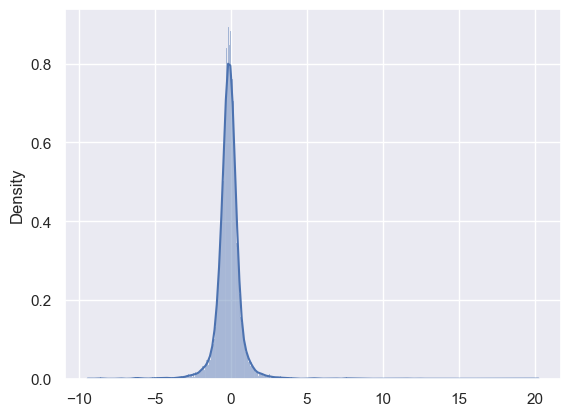

In [37]:
ax = sns.histplot(losses, kde=True, stat='density')

Compute the empirical quantile of the Monte Carlo sample

In [38]:
losses.sort_values(inplace=True)
losses.reset_index(drop=True, inplace=True)
losses.tail()

9995    11.368045
9996    11.624008
9997    12.358199
9998    13.180188
9999    20.221497
dtype: float64

In [40]:
alpha = 0.99
quantile_pos = int(alpha * len(losses))
VaR_MC_cop = losses.iloc[quantile_pos]
ES_MC_cop = losses.iloc[quantile_pos:].mean()
print(f"Value-at-Risk at {alpha:.2%} confidence level = {VaR_MC_cop:.3f} mEUR")
print(f"Expected Shortfall at {alpha:.2%} confidence level = {ES_MC_cop:.3f} mEUR")

Value-at-Risk at 99.00% confidence level = 2.242 mEUR
Expected Shortfall at 99.00% confidence level = 4.334 mEUR
